### Developer: Mayana Mohsin Khan



# Logistic Regression vs. Bayesian Classifier

### Loading packages

In [12]:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

### I. Loading Datasets

In [13]:
train <- read.csv("Task1E_train.csv")
test <- read.csv("Task1E_test.csv")
train.data <- train[,1:2]
train.label <- train[,3]
test.data <- test[,1:2]
test.label <- test[,3]

In [14]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, -log(1-sig), -log(sig)))/nrow(X))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [15]:
logisticModel <- function(train.data, train.label){
    # Initializations
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    train.len = nrow(train.data)
    
    c0 = 1
    c1 = -1
    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label== c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, 0)
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, 0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, 0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, 0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
    }
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    return(w)
}

In [16]:
bayesianModel <- function(train.data, train.label){
    c0 = 1
    c1 = -1
    p0 = 0.60
    p1 = 1 - p0
    p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat
    
    # train data, train label
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])
    
    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    
    # Calculating the result
    train.err = sum(train.label!=train.predict)/nrow(train.data)*100
    test.err = sum(test.label!=test.predict)/nrow(test.data)*100

    return(list(train.err, test.err))
}

In [17]:
sequ <- seq(5,nrow(train.data),5)
df <- data.frame('size'=sequ,'logistic.train'=rep(0,100), 'logistic.test'=rep(0,100), 'BC.train'=rep(0,100), 'BC.test'=rep(0,100))
for (i in 1:length(sequ)){
    n = sequ[i]
             
    batch.data = train.data[1:n,]
    batch.label = train.label[1:n]
    lW.train = logisticModel(batch.data, batch.label)
    train.cost = cost(lW.train, batch.data,batch.label,0)
    test.cost = cost(lW.train, test.data,test.label,0)
    
    BW.train = bayesianModel(batch.data, batch.label)
    
    df[i, 'logistic.train'] = train.cost
    df[i,'BC.train']= BW.train[1]
    df[i, 'logistic.test'] = test.cost
    df[i,'BC.test']= BW.train[2]
    df[i,'size'] = n
}

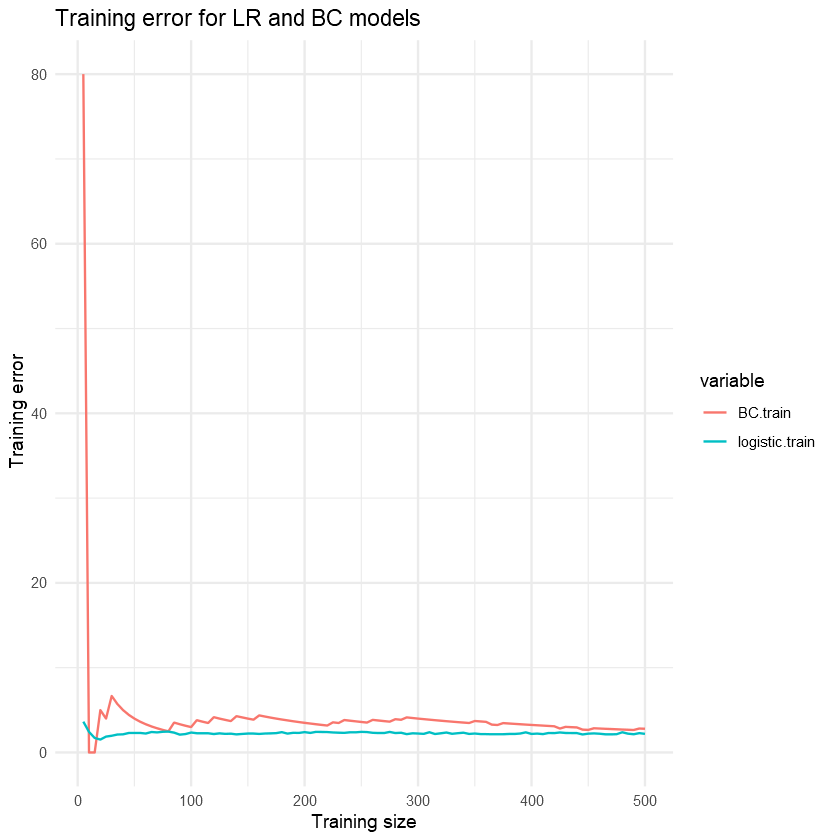

In [18]:
# geom_line(aes(size, BC.train, color='blue')) + xlim(5,500) + theme_gray() 
df.m <- melt(df, id = "size", measure = c("BC.train", "logistic.train"))

# Plot of Training errors of the BC and LR models against datasize
ggplot(df.m, aes(x=size, y=value, color=variable)) + 
    geom_line() + ggtitle('Training error for LR and BC models') + theme_minimal() + xlab("Training size") +  ylab("Training error")

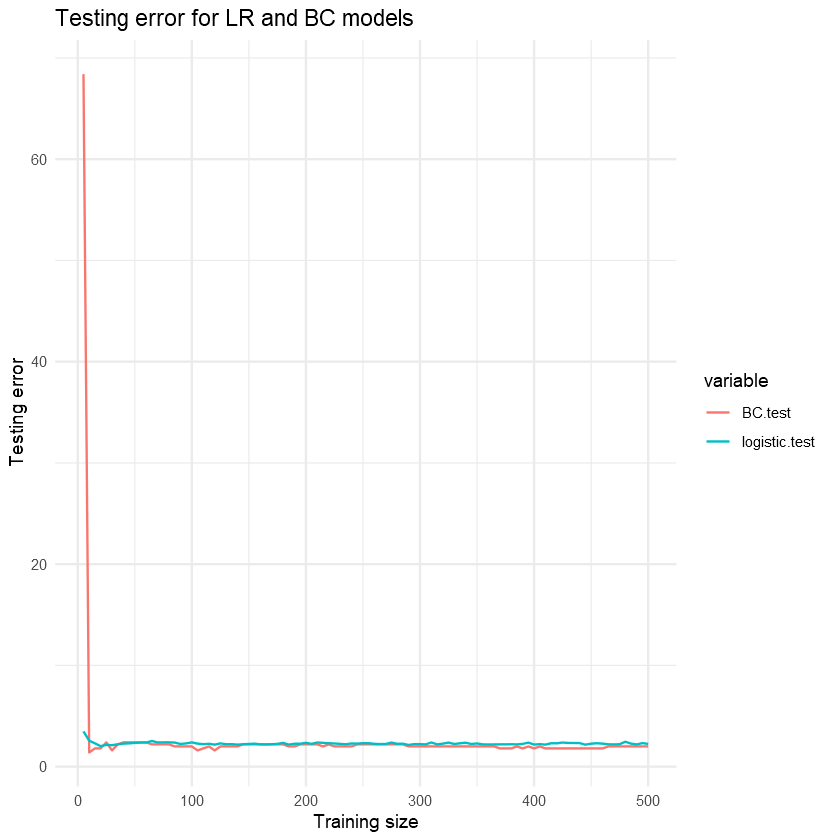

In [19]:
df.m <- melt(df, id = "size", measure = c("BC.test", "logistic.test"))

# Plot of Training errors of the BC and LR models against datasize
ggplot(df.m, aes(x=size, y=value, color=variable)) + 
    geom_line() + ggtitle('Testing error for LR and BC models') + theme_minimal() + xlab("Training size") +  ylab("Testing error")

### III.

#### a. What does happen for each classifier when the number of training data points is increased?
##### ANSWER:
Logistic model preforms if the data size is increased.

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?
##### ANSWER
Bayesian model works good on smaller samples, while logistic is more suitable for larger samples.

#### c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons?
##### ANSWER
Bayesian worked better in the initial batches, however when the batches got increased, the error rate increases as well.
